## Lib

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils.import_df import import_df
from utils.file_processing import check_if_file_exists
from utils.img_preprocessing import get_features_target, img_preprocessing, generate_dataset

2024-04-18 12:37:24.725329: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 12:37:25.610207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 12:37:26.496913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
print(f"GPU is available: {len(tf.config.list_physical_devices('GPU')) > 0}")

GPU is available: False


2024-04-18 12:37:29.244853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 12:37:29.394731: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Vars

In [5]:
csv_url = "../../storage/datas/csv/clean/cleaned_dataset_with_features_and_dimensions_top_10_species.csv"
img_directory = "/home/guillaume/Téléchargements/mushroom_images_dataset/cleaned_dataset/"

## 1 - import DF

### Full Dataset

In [6]:
# Full Dataset
df = import_df(csv_url)

DF loaded with shape: (13819, 16)
Unique species in DF: 11


In [7]:
df["species"].value_counts()

species
Pleurotus ostreatus      1541
Trametes versicolor      1537
Lepista nuda             1351
Boletus edulis           1322
other                    1240
Hypholoma fasciculare    1236
Pluteus cervinus         1234
Ganoderma applanatum     1137
Psilocybe cyanescens     1132
Galerina marginata       1115
Psilocybe zapotecorum     974
Name: count, dtype: int64

In [8]:
# Add image_path column & reload
df["image_path"] = df["image_lien"].apply(lambda x: os.path.join(img_directory, x))
df.to_csv(csv_url, index=False)
df = import_df(csv_url)

DF loaded with shape: (13819, 16)
Unique species in DF: 11


### Sample

In [9]:
# 10% Sample
df_sample_10 = import_df(csv_url,
                         sample = True,
                         sample_size = 0.1,
                         random_state=1)

DF sampled with 10.0% from original dataset, shape: (1382, 16)
Unique species in sampled DF: 11


In [10]:
df_sample_10["species"].value_counts()

species
Pleurotus ostreatus      177
Trametes versicolor      158
Ganoderma applanatum     139
Boletus edulis           125
Hypholoma fasciculare    125
Lepista nuda             122
Pluteus cervinus         121
Galerina marginata       116
other                    107
Psilocybe cyanescens      97
Psilocybe zapotecorum     95
Name: count, dtype: int64

## 2 - Check if all image files exist

In [11]:
check_if_file_exists(img_directory,
                     csv_url,
                     column = "image_path",
                     auto_clean_csv=False)

## 3 - Df column selection

In [12]:
target_column = "species"
img_link_column = "image_path"

In [13]:
df = df[[target_column, img_link_column]]
df_sample_10 = df_sample_10[[target_column, img_link_column]]

## 4 - Features & Targets

### Features & Targets generation

In [14]:
# Get features & target
df_features, df_target = get_features_target(df, target_column_name = "species")
df_sample_10_features, df_sample_10_target = get_features_target(df_sample_10, target_column_name = "species")

### Img Load & Preprocessing

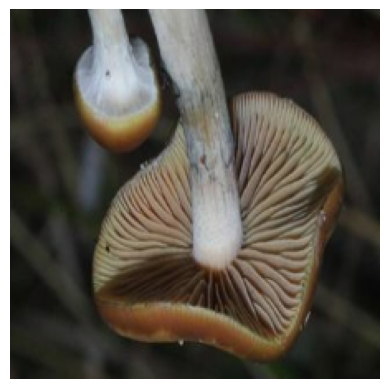

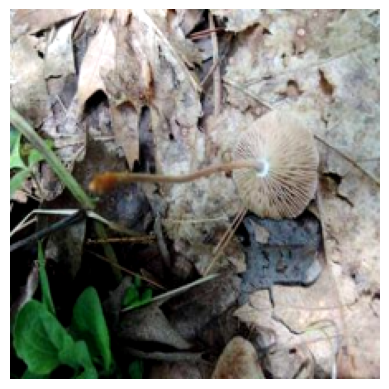

In [15]:
# Try random images pre-processing
n_random = 2
random_images = df_features["image_path"].sample(n_random)

img_preprocessing_args = {
    "dimensions": (224,224),
    "resize": True,
    "augment": True,
    "normalize": True,
    "flip_left_right": True,
    "flip_up_down": True,
    "brightness": True,
    "contrast": True,
    "saturation": False,
}

for elt in random_images:
    img = img_preprocessing(elt, **img_preprocessing_args)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Tensorflow dataset generation

#### Sample datasets

In [16]:
train_dataset, val_dataset, test_dataset = generate_dataset(df_sample_10_target, df_sample_10_features["image_path"],
                                                            train_size = 0.8, test_size = 0.5, random_state = 10,
                                                            img_dimensions = (224,224), resize = True,
                                                            augment = True, normalize = True,
                                                            flip_left_right = True,
                                                            flip_up_down = True,
                                                            brightness = True,
                                                            contrast = True,
                                                            saturation = False,
                                                            batch_size = 32)

Encoded target: [ 2  3  7 ... 10  8 10]
Label mapping: {'Boletus edulis': 0, 'Galerina marginata': 1, 'Ganoderma applanatum': 2, 'Hypholoma fasciculare': 3, 'Lepista nuda': 4, 'Pleurotus ostreatus': 5, 'Pluteus cervinus': 6, 'Psilocybe cyanescens': 7, 'Psilocybe zapotecorum': 8, 'Trametes versicolor': 9, 'other': 10}
Train, validation & test splits created successfully.

 Current shapes: 
 X_train: (1105,) 
 X_val: (138,) 
 X_test: (139,) 
Train dataset generated successfully. Number of batches: 35
Validation dataset generated successfully. Number of batches: 5
Test dataset generated successfully. Number of batches: 5


#### Full datasets

In [17]:
train_dataset, val_dataset, test_dataset = generate_dataset(df_target, df_features["image_path"],
                                                            train_size = 0.8, test_size = 0.5, random_state = 10,
                                                            img_dimensions = (224,224), resize = True,
                                                            augment = True, normalize = True,
                                                            flip_left_right = True,
                                                            flip_up_down = True,
                                                            brightness = True,
                                                            contrast = True,
                                                            saturation = False,
                                                            batch_size = 64)

Encoded target: [ 9  9  9 ... 10 10 10]
Label mapping: {'Boletus edulis': 0, 'Galerina marginata': 1, 'Ganoderma applanatum': 2, 'Hypholoma fasciculare': 3, 'Lepista nuda': 4, 'Pleurotus ostreatus': 5, 'Pluteus cervinus': 6, 'Psilocybe cyanescens': 7, 'Psilocybe zapotecorum': 8, 'Trametes versicolor': 9, 'other': 10}
Train, validation & test splits created successfully.

 Current shapes: 
 X_train: (11055,) 
 X_val: (1382,) 
 X_test: (1382,) 
Train dataset generated successfully. Number of batches: 173
Validation dataset generated successfully. Number of batches: 22
Test dataset generated successfully. Number of batches: 22


#### Save Datasets

In [18]:
# Save datasets
path_save_dataset = "../../storage/datas/tf_datasets/"
path_save_train_dataset = os.path.join(path_save_dataset, "train_dataset")
path_save_val_dataset = os.path.join(path_save_dataset, "val_dataset")
path_save_test_dataset = os.path.join(path_save_dataset, "test_dataset")


tf.data.Dataset.save(train_dataset, path_save_train_dataset)
tf.data.Dataset.save(val_dataset, path_save_val_dataset)
tf.data.Dataset.save(test_dataset, path_save_test_dataset)